https://deep-learning-study.tistory.com/681

https://deep-learning-study.tistory.com/476

https://pypi.org/project/facenet-pytorch/

In [ ]:
!pip install facenet-pytorch

In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from PIL import Image

In [4]:
# Initialize MTCNN for face detection
mtcnn = MTCNN(keep_all=True)

# Load pre-trained FaceNet model
resnet = InceptionResnetV1(pretrained='casia-webface').eval() # vggface2

  0%|          | 0.00/111M [00:00<?, ?B/s]

In [8]:
import os
os.chdir('/facenet/img')
flist = os.listdir()
imglist = sorted(flist)

In [ ]:
# 단일 이미지 임베딩 확인
# Load an image containing faces
img = Image.open('Baekhyeon01.jpg')
img = img.convert('RGB')

# Detect faces in the image
boxes, _ = mtcnn.detect(img)

# If faces are detected, extract embeddings
if boxes is not None:
    aligned = mtcnn(img)
    emb = resnet(aligned).detach().numpy().flatten()
    print(len(emb))

In [47]:
# 임베딩 길이 다른 것 확인 (사진 하나에 박스가 하나 이상)
cnt = 0
for i in range(len(imglist)):
  # Load an image containing faces
  img = Image.open(imglist[i])
  img = img.convert('RGB')

  # Detect faces in the image
  boxes, _ = mtcnn.detect(img)

  # If faces are detected, extract embeddings
  if boxes is not None:
      aligned = mtcnn(img)
      emb = resnet(aligned).detach().numpy().flatten()
      cnt += 1
      if len(emb) != 512:
        print(len(emb), imglist[i])

print(cnt)

80


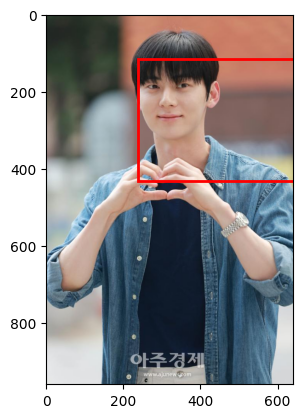

In [74]:
# 이미지 출력
import matplotlib.pyplot as plt
import matplotlib.patches as patches

img = Image.open('Hwangminhyeon19.jpg')
img = img.convert('RGB')

# Detect faces in the image
boxes, _ = mtcnn.detect(img)

# If faces are detected, extract embeddings
if boxes is not None:
    # Plot image
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    # Draw bounding boxes
    for box in boxes:
        # Extract box coordinates
        x, y, width, height = box
        # Create a rectangle patch
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        # Add the patch to the plot
        ax.add_patch(rect)

In [52]:
import pandas as pd
data = {'filename': [], 'emb': []}

for i in range(len(imglist)):
  # Load an image containing faces
  img = Image.open(imglist[i])
  img = img.convert('RGB')

  # Detect faces in the image
  boxes, _ = mtcnn.detect(img)

  # If faces are detected, extract embeddings
  if boxes is not None:
      aligned = mtcnn(img)
      emb = resnet(aligned).detach().numpy().flatten()
      data['filename'].append(imglist[i])
      data['emb'].append(emb)

In [54]:
df = pd.DataFrame(data)
# df.to_csv('fasenet_emb.csv', index=False)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# 코사인 유사도 계산을 위한 함수 정의
def compute_cosine_similarity(emb1, emb2):
    similarity = cosine_similarity([emb1], [emb2])
    return similarity[0][0]

# 각 이미지 간의 코사인 유사도 계산
similarities = []
for i in range(len(df)):
    emb1 = df.loc[i, 'emb']
    filename1 = df.loc[i, 'filename']
    for j in range(i + 1, len(df)):
        emb2 = df.loc[j, 'emb']
        filename2 = df.loc[j, 'filename']
        similarity = compute_cosine_similarity(emb1, emb2)
        similarities.append({'filename1': filename1, 'filename2': filename2, 'similarity': similarity})

# 결과를 데이터프레임으로 변환
sim_df = pd.DataFrame(similarities)
# print(sim_df)

In [59]:
# sim_df.to_csv('fasenet_sim.csv', index=False)

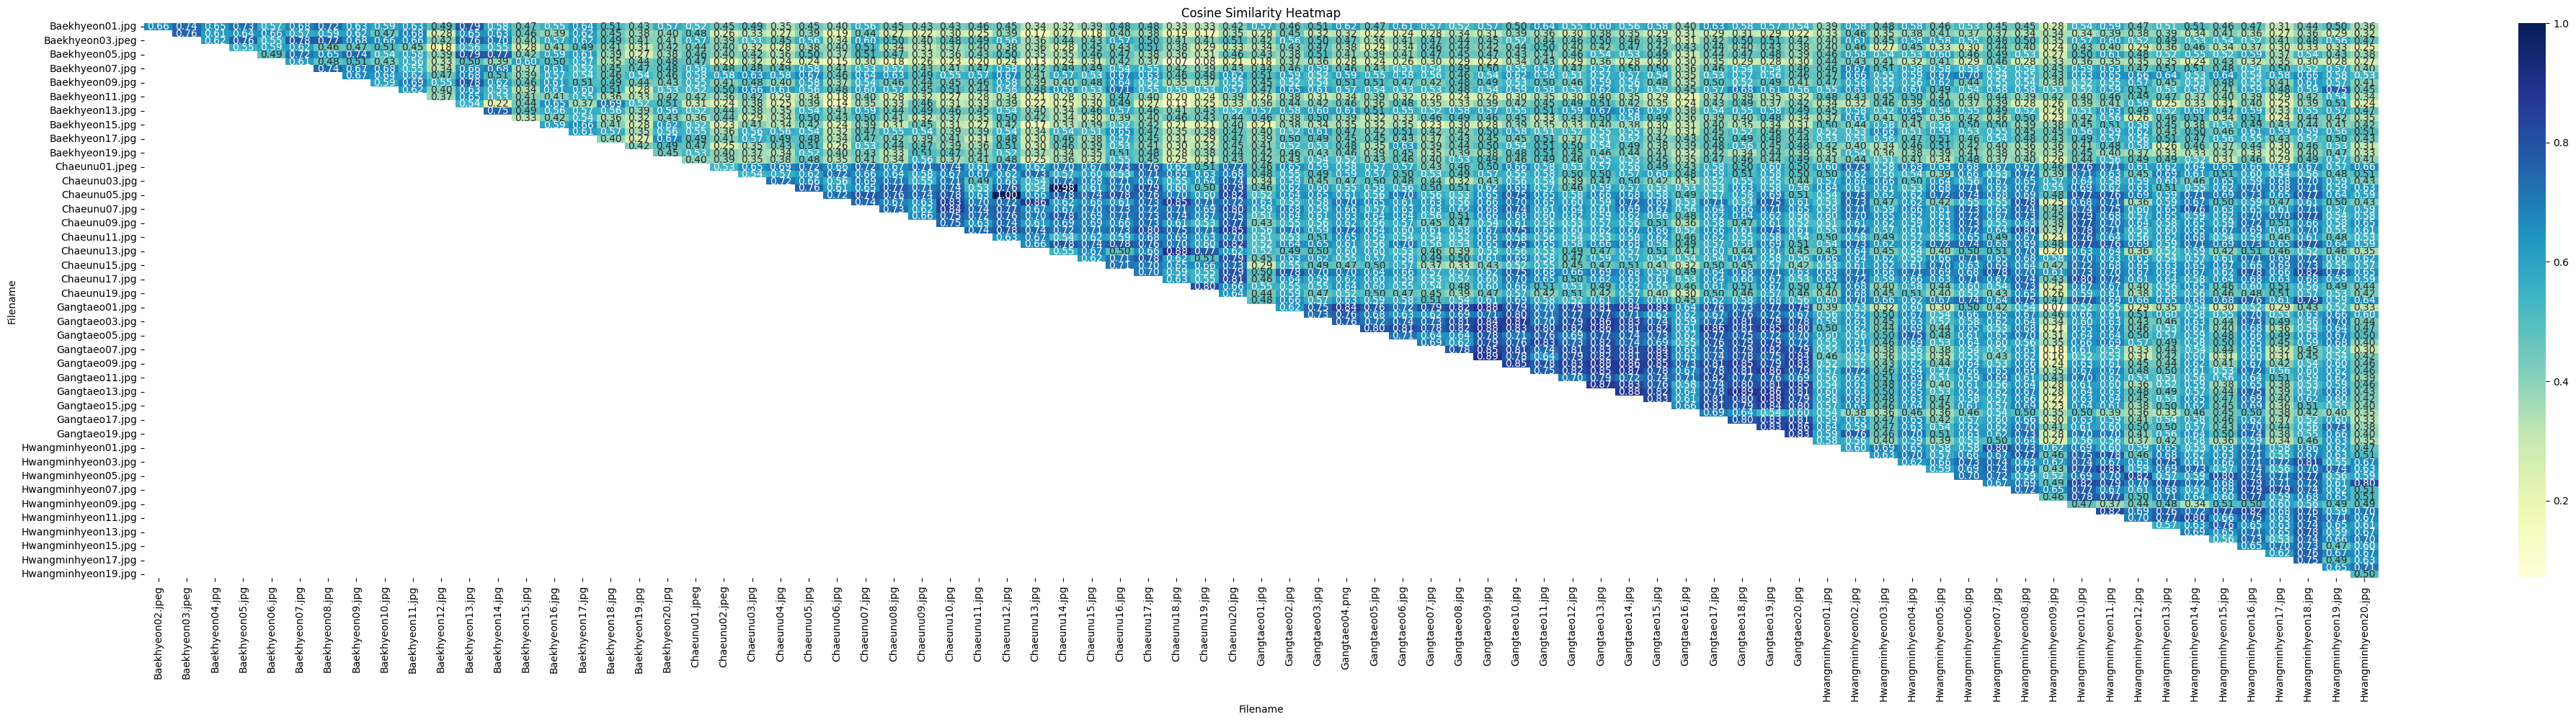

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# 피벗 테이블 생성
pivot_table = sim_df.pivot(index='filename1', columns='filename2', values='similarity')

# 히트맵 생성
plt.figure(figsize=(50, 10))
sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt=".2f")
plt.title('Cosine Similarity Heatmap')
plt.xlabel('Filename')
plt.ylabel('Filename')
plt.show()

In [73]:
import numpy as np
# Find the pair with the highest similarity (excluding 1.0 and same filenames)
max_similarity = 0
max_similarity_indices = (0, 0)

for i in range(len(pivot_table)):
    for j in range(i + 1, len(pivot_table)):
        similarity = pivot_table.iloc[i, j]
        if similarity < 1.0 and pivot_table.index[i] != pivot_table.columns[j] and similarity > max_similarity:
            max_similarity = similarity
            max_similarity_indices = (i, j)

filename1 = pivot_table.index[max_similarity_indices[0]]
filename2 = pivot_table.columns[max_similarity_indices[1]]

print(f"The most similar pair of images: {filename1} and {filename2}, similarity: {max_similarity}")

The most similar pair of images: Chaeunu04.jpg and Chaeunu14.jpg, similarity: 0.9812521934509277
